مرحله اول: استخراج داده های مربوط به هر ردیف پادکست انجام شد و همچنین لینک های سالم که دارای وضعیت برابر 200 می باشد در نظر گرفته شده است



In [ ]:
import requests
from lxml import etree
import pandas as pd

# خواندن دیتافریم از فایل csv
df = pd.read_csv('podcasts_en_1.csv', encoding='latin1')

# تعریف تابع برای استخراج اطلاعات از RSS
def extract_rss_data(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            response.encoding = 'utf-8'  # مشخص کردن رمزگذاری
            root = etree.fromstring(response.content)
            items = []
            for item in root.findall('.//item'):
                item_data = {}
                item_data['title'] = item.findtext('title')
                item_data['description'] = item.findtext('description')
                item_data['pubDate'] = item.findtext('pubDate')
                item_data['author'] = item.findtext('author')
                item_data['link'] = item.findtext('link')
                enclosure = item.find('enclosure')
                item_data['enclosure_url'] = enclosure.get('url') if enclosure is not None else None
                item_data['itunes_title'] = item.findtext('itunes:title', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                item_data['itunes_author'] = item.findtext('itunes:author', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                itunes_image = item.find('itunes:image', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                item_data['itunes_image'] = itunes_image.get('href') if itunes_image is not None else None
                item_data['itunes_duration'] = item.findtext('itunes:duration', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                item_data['itunes_summary'] = item.findtext('itunes:summary', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                item_data['itunes_subtitle'] = item.findtext('itunes:subtitle', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                item_data['itunes_explicit'] = item.findtext('itunes:explicit', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                item_data['itunes_episodeType'] = item.findtext('itunes:episodeType', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                item_data['itunes_episode'] = item.findtext('itunes:episode', namespaces={'itunes': 'http://www.itunes.com/dtds/podcast-1.0.dtd'})
                items.append(item_data)
            return items
        else:
            return None
    except requests.exceptions.RequestException as e:
        print(f"RequestException: {e} for URL: {url}")
        return None
    except etree.XMLSyntaxError as e:
        print(f"XMLSyntaxError: {e} for URL: {url}")
        return None

# ایجاد ستون‌های جدید در دیتافریم برای ذخیره اطلاعات استخراج شده
new_columns = ['title', 'description', 'pubDate', 'author', 'link', 'enclosure_url',
               'itunes_title', 'itunes_author', 'itunes_image', 'itunes_duration',
               'itunes_summary', 'itunes_subtitle', 'itunes_explicit', 'itunes_episodeType', 'itunes_episode']
for col in new_columns:
    df[col] = None

# اضافه کردن ستون برای نشان دادن وضعیت دریافت لینک
df['status_200'] = False

# پیمایش تمام ردیف‌های دیتافریم و استخراج اطلاعات از هر آدرس
for index, row in df.iterrows():
    url = row['rss_link']  # نام ستونی که حاوی آدرس‌ها است
    podcast_name = row['podcast_name']  # نام ستونی که حاوی نام پادکست‌ها است
    rss_data = extract_rss_data(url)
    if rss_data:
        df.at[index, 'status_200'] = True
        for item in rss_data:
            for col in new_columns:
                df.at[index, col] = item[col]

# فیلتر کردن ردیف‌هایی که وضعیت دریافت لینک آن‌ها 200 است
filtered_df = df[df['status_200'] == True]

# ذخیره کردن دیتافریم فیلتر شده در یک فایل اکسل
filtered_df.to_csv('podcasts_en.csv', index=False)

مرحله دوم: کتابخانه های مورد نیاز را نصب می کنیم

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00


مرحله سوم: کتابخانه های مورد نیاز را به پروژه اضافه می کنیم

In [ ]:
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

مرحله چهارم: داده ها را فراخوانی می کنیم

In [ ]:
data = pd.read_csv('podcasts_end.csv')

answer 1: bert-base-uncased + DBSCAN + UMAP

<ipython-input-4-818be20968de>:11: DtypeWarning: Columns (2,3,8,9,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275

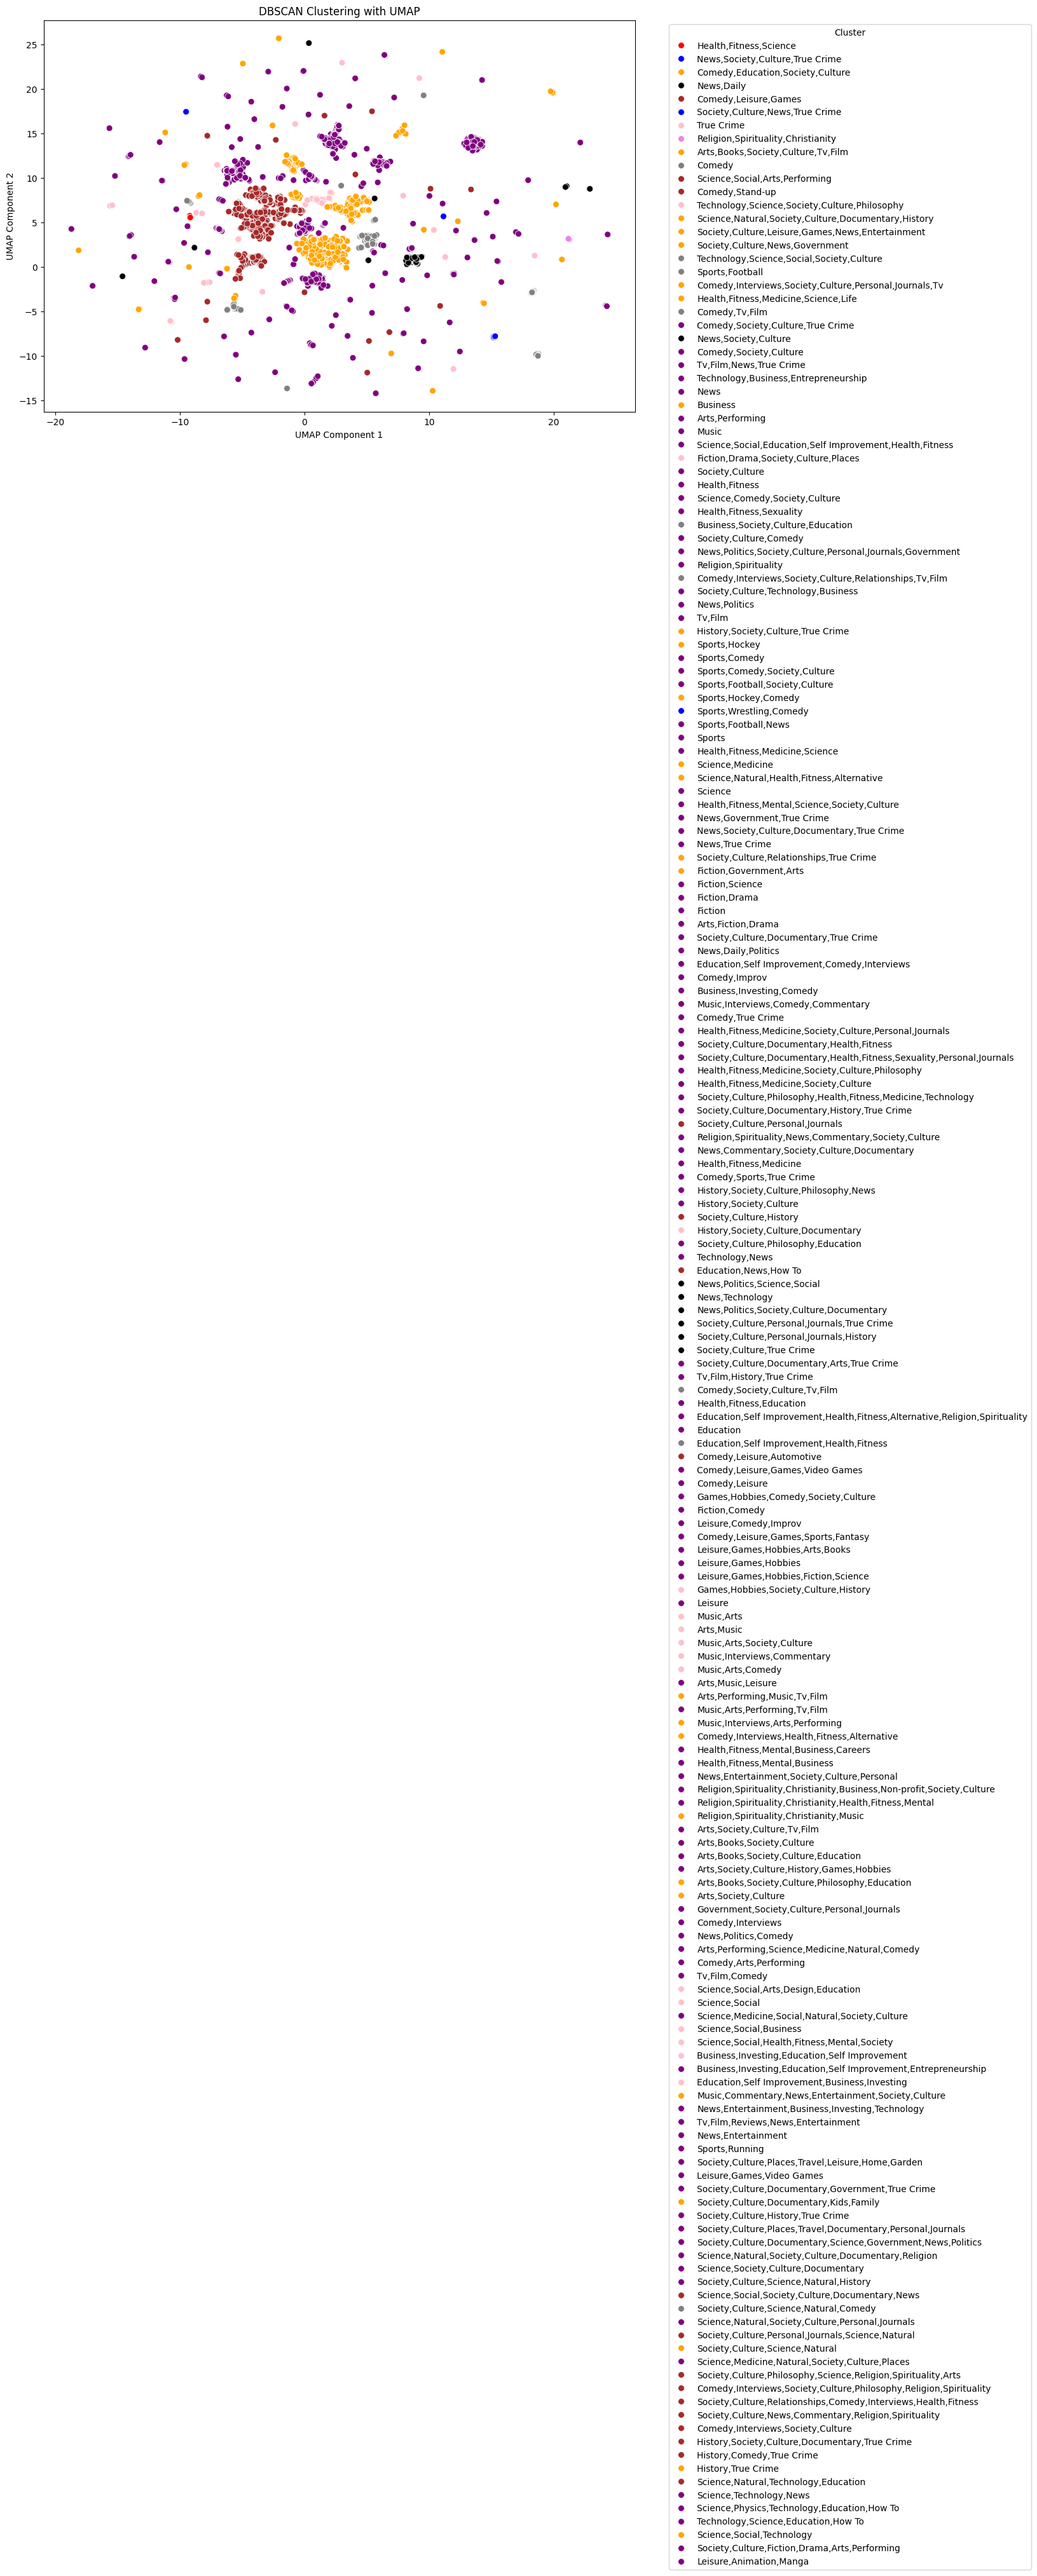

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import umap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure all category values are strings
data['categories'] = data['categories'].astype(str)

# Tokenization
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model for embeddings
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# Function to encode texts
def encode_texts(texts, tokenizer, model, device):
    encoded_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        encoded_texts.append(embeddings)
    return np.array(encoded_texts)

# Encode the text data
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# Dimensionality reduction with UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(encoded_texts)

# Clustering with DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(umap_embeddings)

# Define default cluster colors
default_cluster_colors = {
    -1: "green",
    0: "red",
    1: "blue",
    2: "orange",
    3: "black",
    4: "brown",
    5: "pink",
    6: "violet",
    7: "gray"
}

# Map labels to category names and colors
unique_categories = data['categories'].unique()
category_names = {i: unique_categories[i] if i < len(unique_categories) else f"Cluster {i}" for i in np.unique(labels)}
category_colors = {i: default_cluster_colors[i] if i in default_cluster_colors else "purple" for i in np.unique(labels)}

# Map labels to cluster names and colors
cluster_labels = [category_names[label] for label in labels]
cluster_palette = [category_colors[label] for label in labels]

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)
plt.title('DBSCAN Clustering with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


answer2 : roberta-base + DBSCAN + UMAP

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-5-c956864830b3>:55: UserWarning: The palette list has more values (10897) than needed (207), which may not be intended.
  sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)


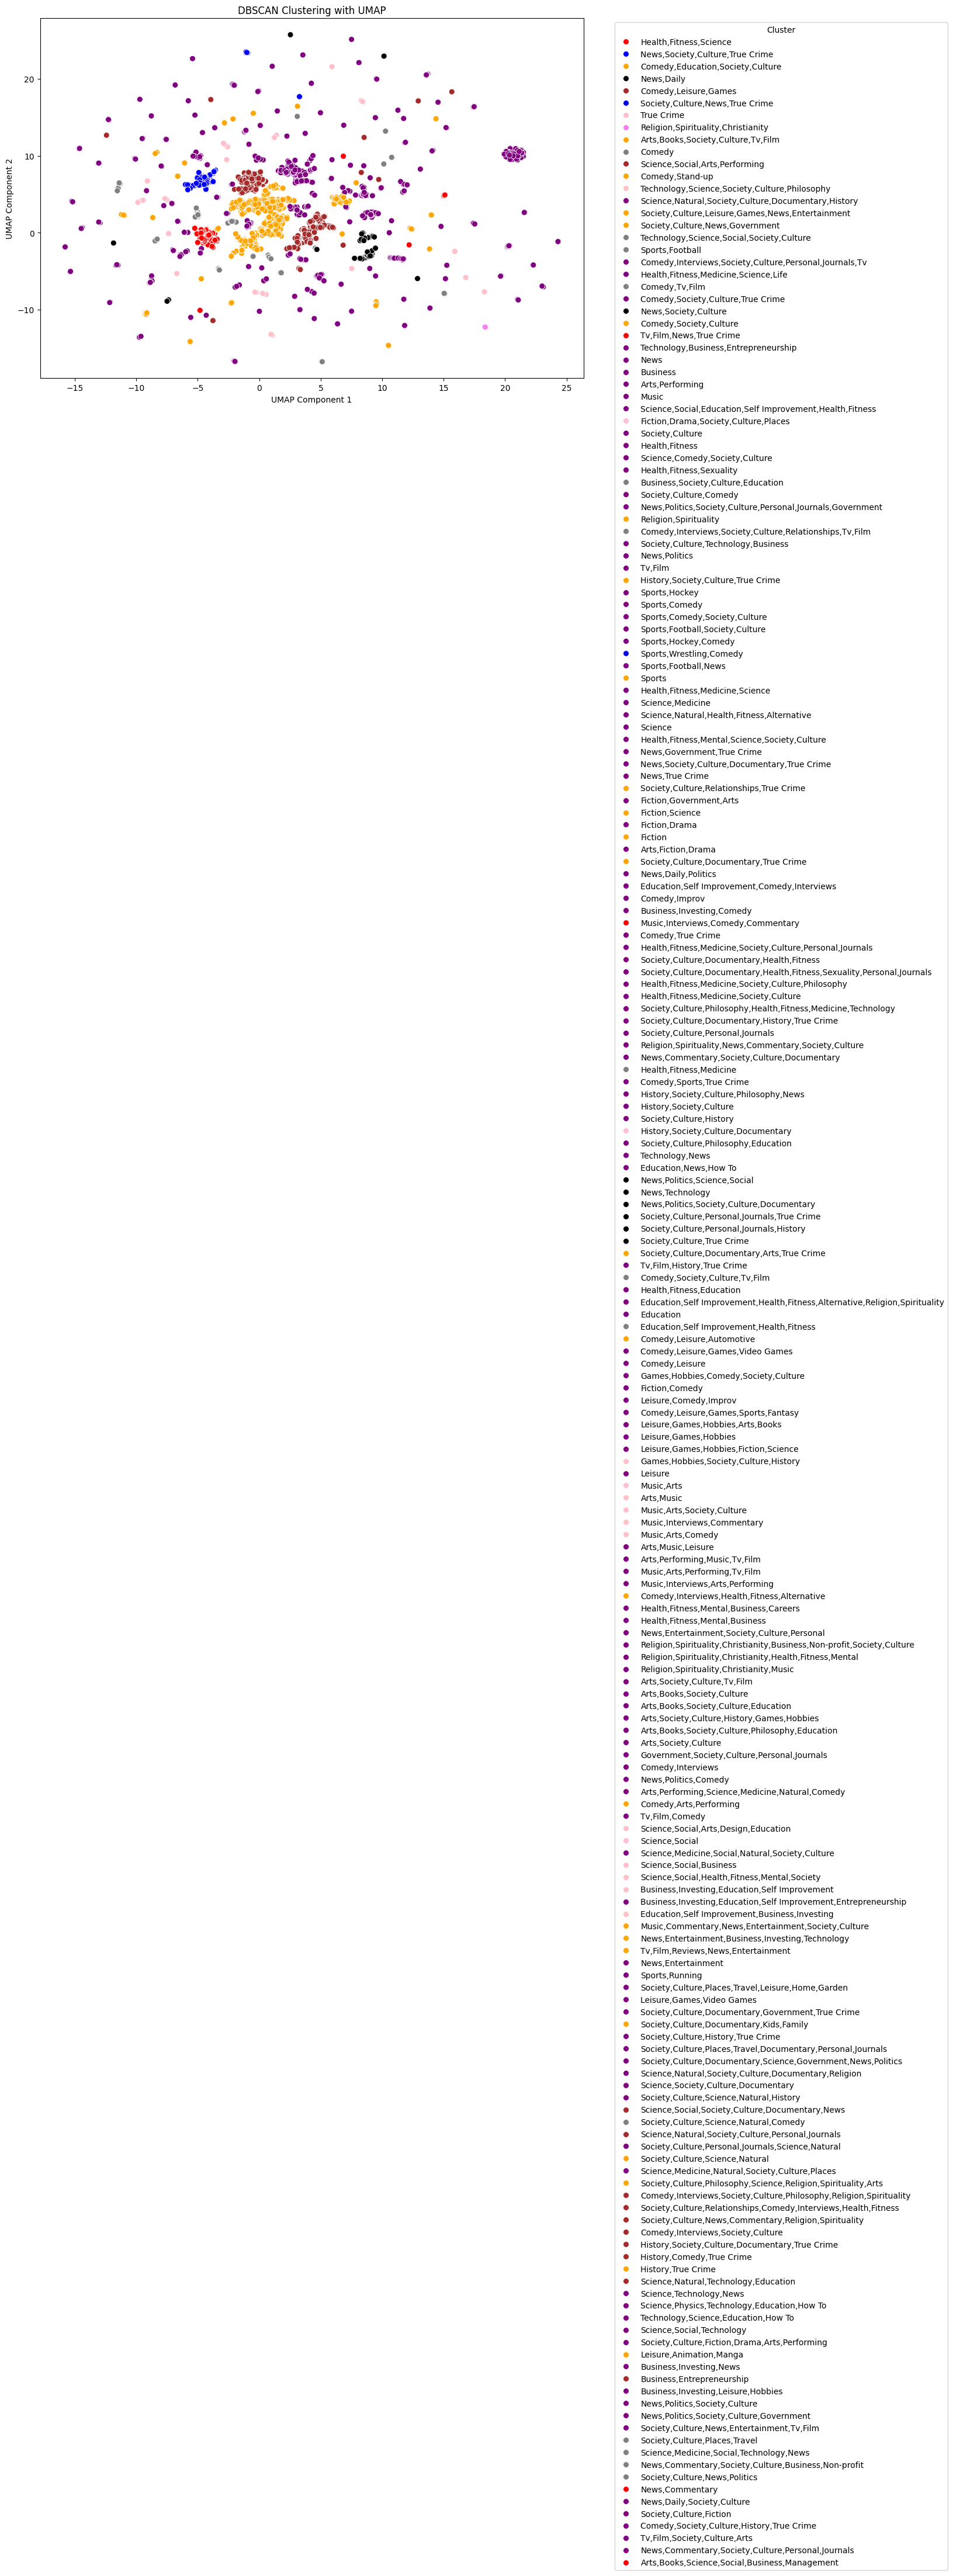

In [ ]:
# Tokenization
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model for embeddings
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# Function to encode texts
def encode_texts(texts, tokenizer, model, device):
    encoded_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        encoded_texts.append(embeddings)
    return np.array(encoded_texts)

# Encode the text data
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# Dimensionality reduction with UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(encoded_texts)

# Clustering with DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(umap_embeddings)

# Define default cluster colors
default_cluster_colors = {
    -1: "green",
    0: "red",
    1: "blue",
    2: "orange",
    3: "black",
    4: "brown",
    5: "pink",
    6: "violet",
    7: "gray"
}

# Map labels to category names and colors
unique_categories = data['categories'].unique()
category_names = {i: unique_categories[i] if i < len(unique_categories) else f"Cluster {i}" for i in np.unique(labels)}
category_colors = {i: default_cluster_colors[i] if i in default_cluster_colors else "purple" for i in np.unique(labels)}

# Map labels to cluster names and colors
cluster_labels = [category_names[label] for label in labels]
cluster_palette = [category_colors[label] for label in labels]

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)
plt.title('DBSCAN Clustering with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


answer3: roberta-base + DBSCAN + PCA

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-a7f33b348e1d>:57: UserWarning: The palette list has more values (10897) than needed (1), which may not be intended.
  sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)


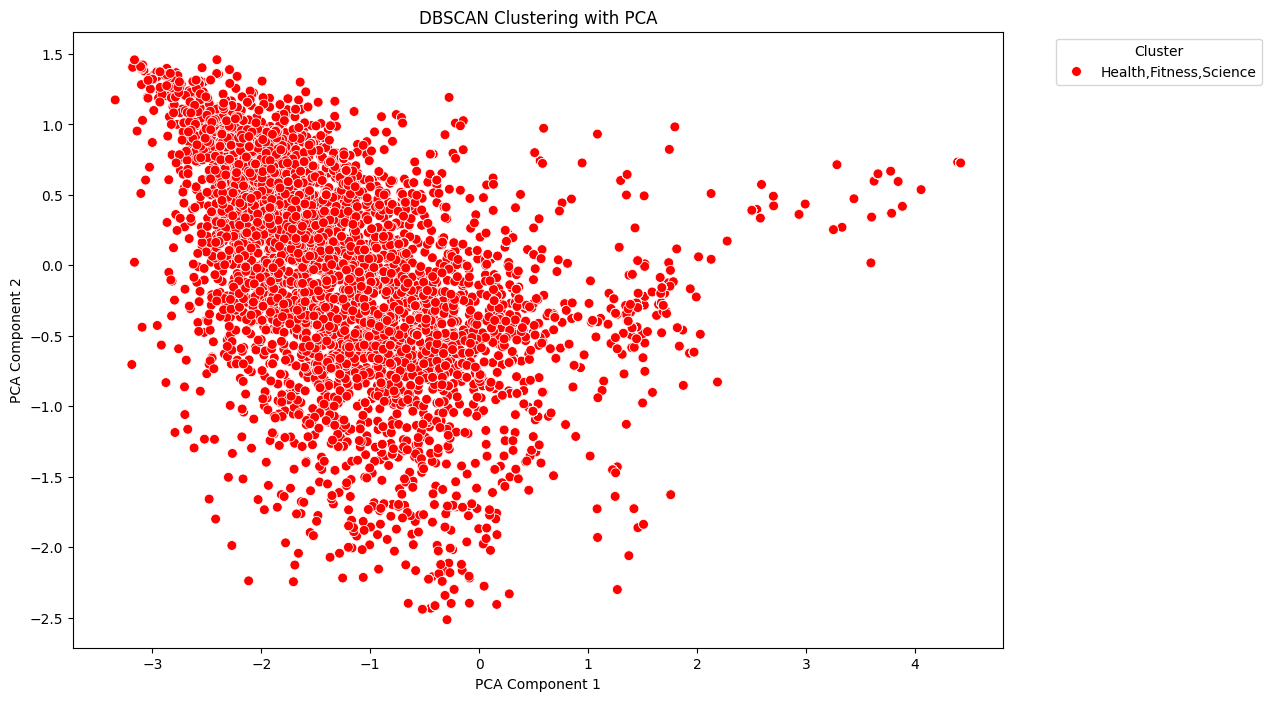

In [ ]:
# Tokenization
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model for embeddings
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# Function to encode texts
def encode_texts(texts, tokenizer, model, device):
    encoded_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        encoded_texts.append(embeddings)
    return np.array(encoded_texts)

# Encode the text data
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(encoded_texts)

# Clustering with DBSCAN
dbscan = DBSCAN(eps=0.75, min_samples=10, metric='euclidean')
labels = dbscan.fit_predict(pca_embeddings)

# Define distinct cluster colors
cluster_colors = {
    -1: "green",
    0: "red",
    1: "blue",
    2: "orange",
    3: "purple",
    4: "brown",
    5: "pink",
    6: "cyan",
    7: "olive",
    8: "gray",
    9: "magenta"
}

# Map labels to category names and colors
unique_categories = data['categories'].unique()
category_names = {i: unique_categories[i] if i < len(unique_categories) else f"Cluster {i}" for i in np.unique(labels)}
category_colors = {i: cluster_colors[i] if i in cluster_colors else "black" for i in np.unique(labels)}

# Map labels to cluster names and colors
cluster_labels = [category_names[label] for label in labels]
cluster_palette = [category_colors[label] for label in labels]

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)
plt.title('DBSCAN Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


answer4: bert-base-uncased + DBSCAN + UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-9-fdb3abecd655>:60: UserWarning: The palette list has more values (10897) than needed (154), which may not be intended.
  sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)


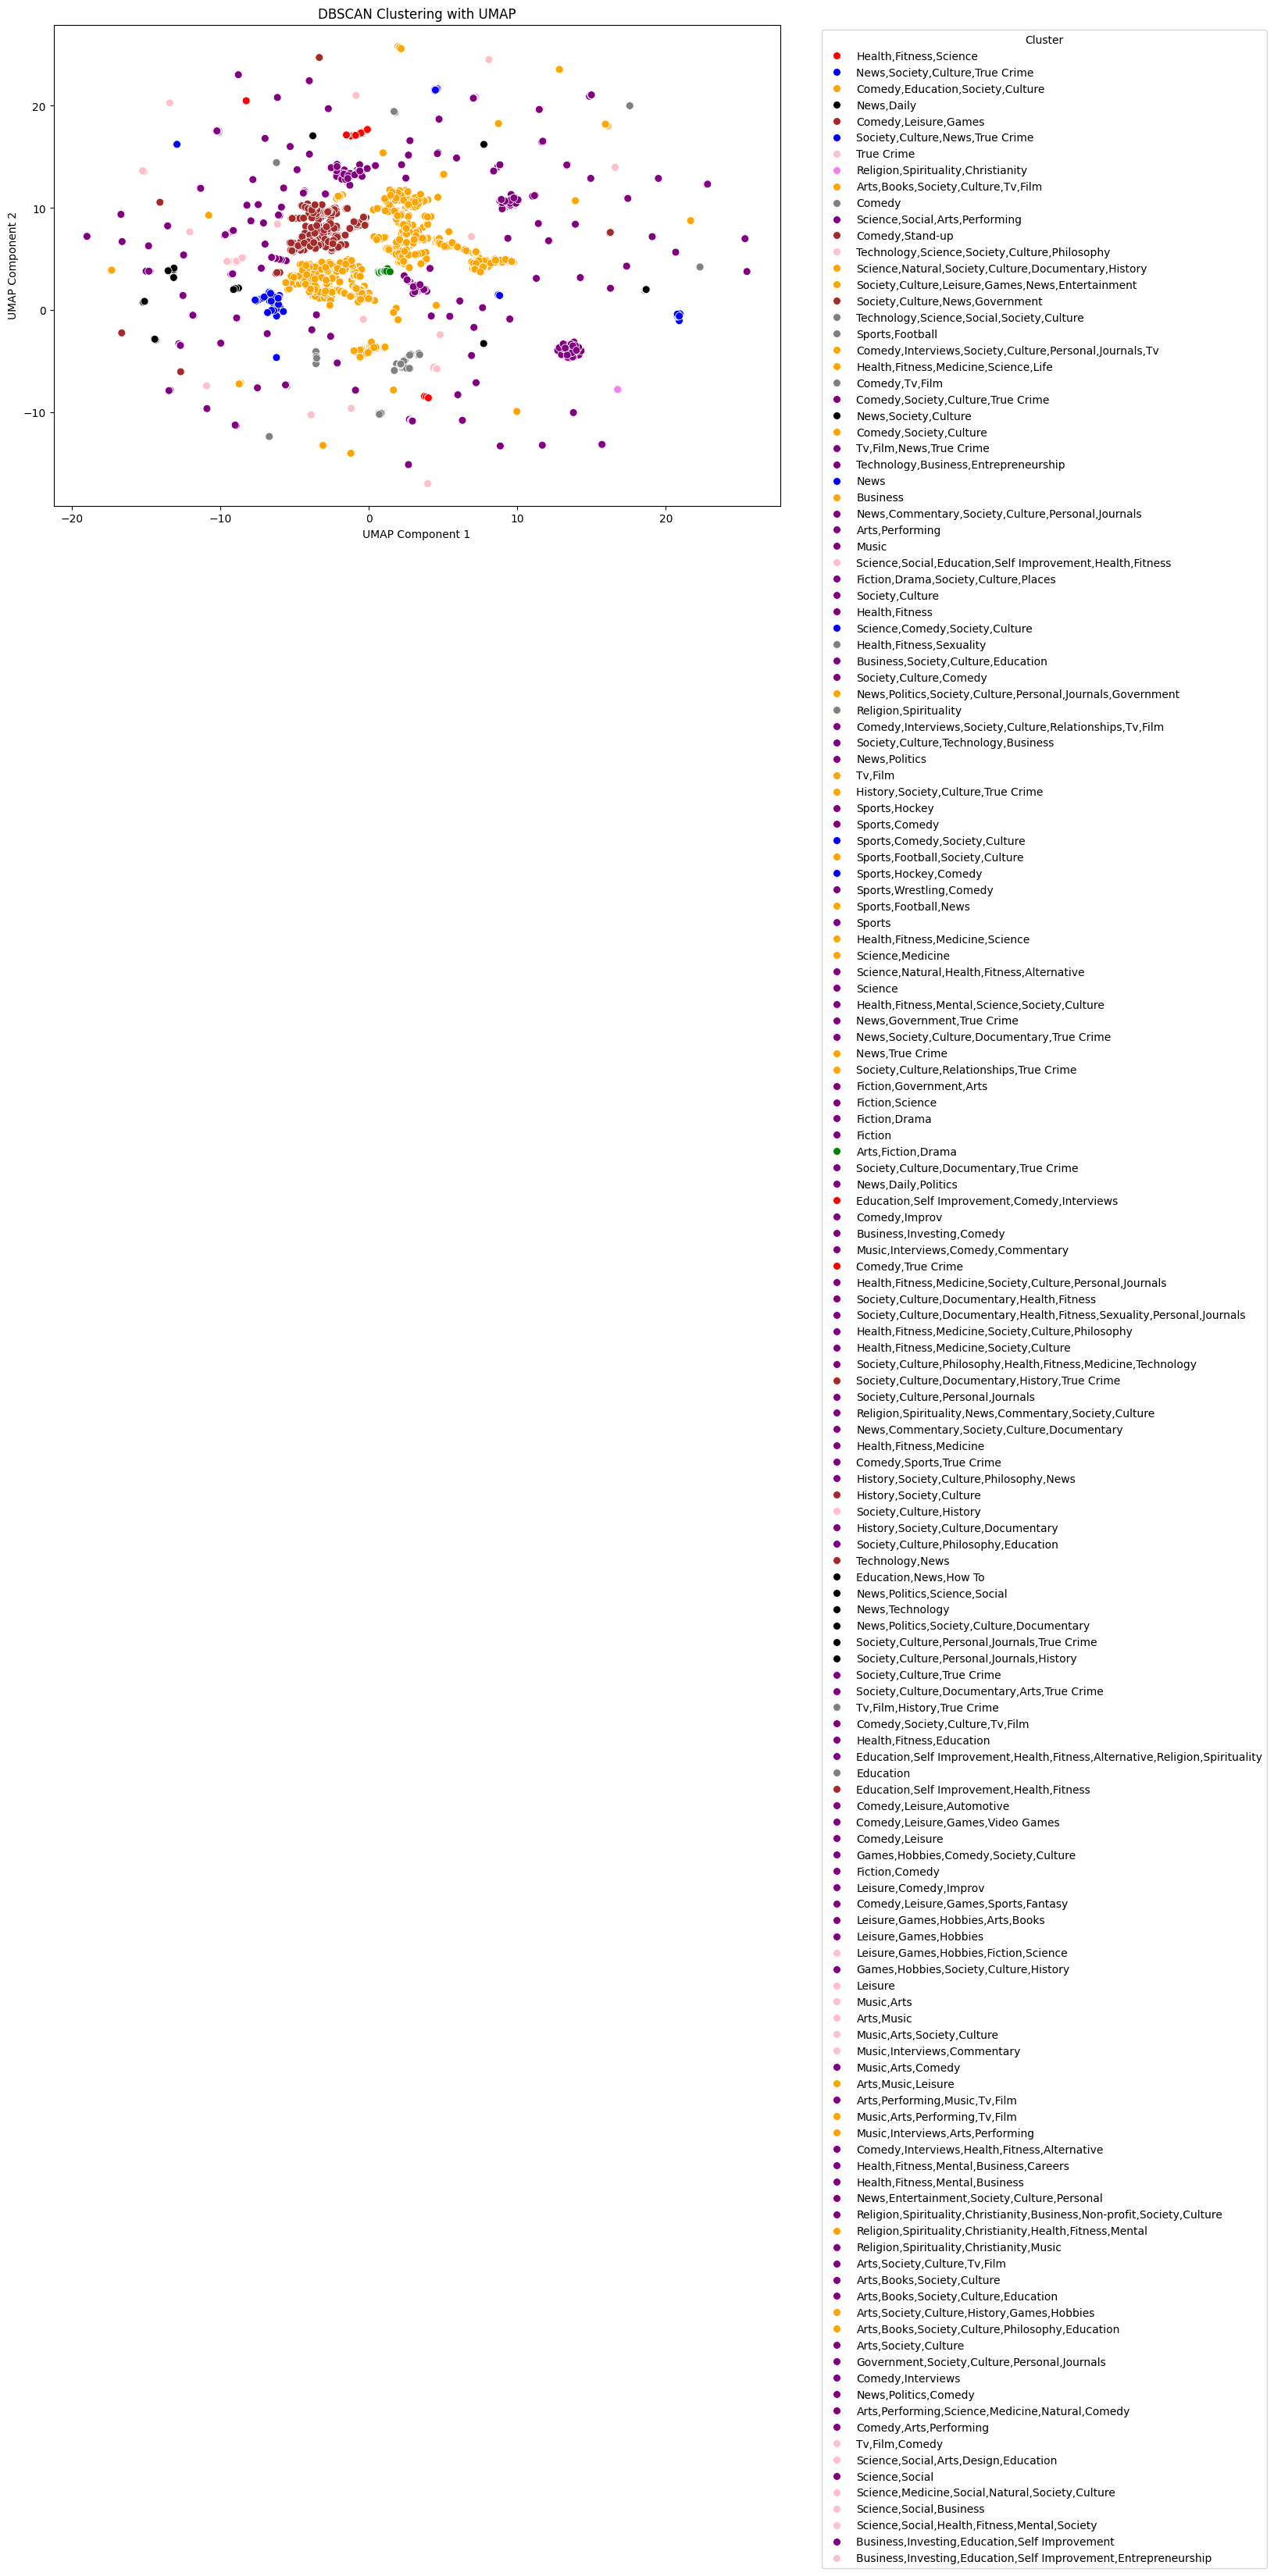

In [ ]:
# Tokenization
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model for embeddings
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# Function to encode texts
def encode_texts(texts, tokenizer, model, device):
    encoded_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        encoded_texts.append(embeddings)
    return np.array(encoded_texts)

# Encode the text data
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# Dimensionality reduction with UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(encoded_texts)

# Clustering with DBSCAN
#dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
#labels = dbscan.fit_predict(umap_embeddings)

# Clustering with DBSCAN with adjusted parameters
dbscan = DBSCAN(eps=0.7, min_samples=10, metric='euclidean')
labels = dbscan.fit_predict(umap_embeddings)


# Define default cluster colors
default_cluster_colors = {
    -1: "green",
    0: "red",
    1: "blue",
    2: "orange",
    3: "black",
    4: "brown",
    5: "pink",
    6: "violet",
    7: "gray"
}

# Map labels to category names and colors
unique_categories = data['categories'].unique()
category_names = {i: unique_categories[i] if i < len(unique_categories) else f"Cluster {i}" for i in np.unique(labels)}
category_colors = {i: default_cluster_colors[i] if i in default_cluster_colors else "purple" for i in np.unique(labels)}

# Map labels to cluster names and colors
cluster_labels = [category_names[label] for label in labels]
cluster_palette = [category_colors[label] for label in labels]

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)
plt.title('DBSCAN Clustering with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


answer5: bert-base-uncased + UMAP + KMEANS

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-11-a1a71f9b4144>:59: UserWarning: The palette list has more values (10897) than needed (12), which may not be intended.
  sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)


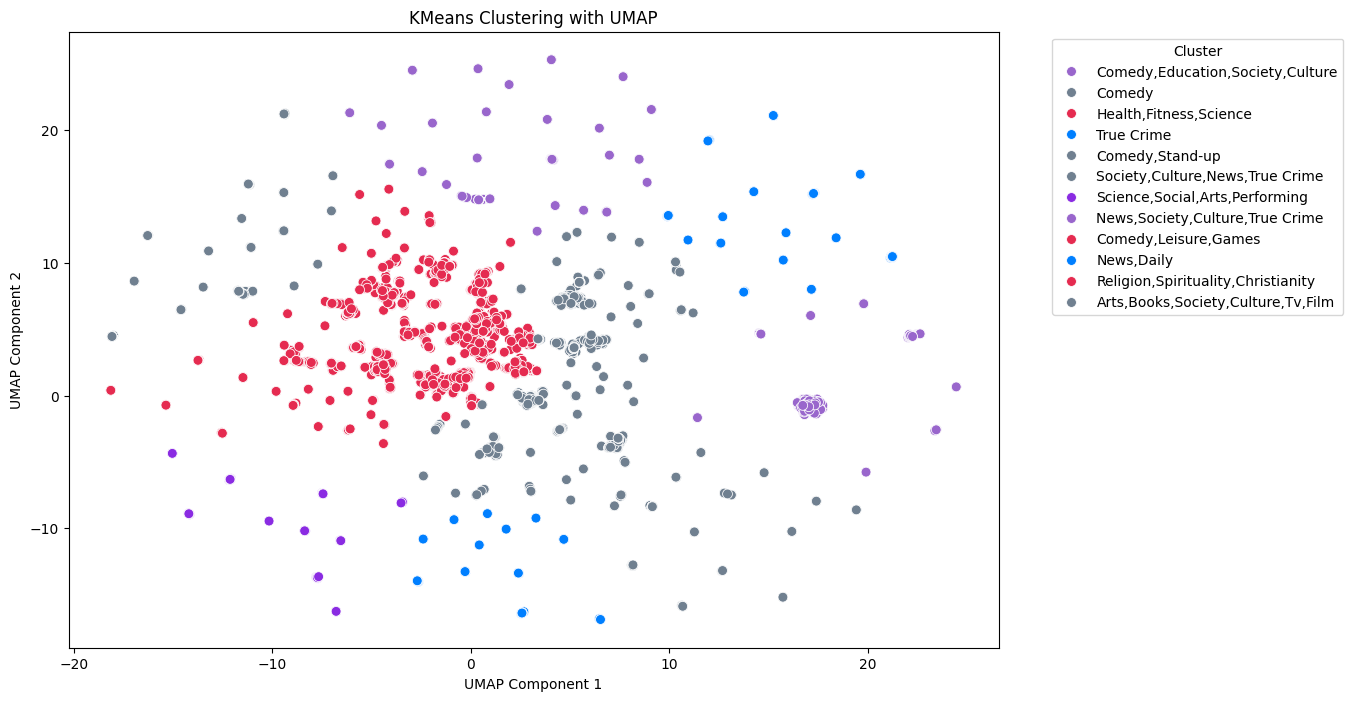

In [ ]:
# Tokenization
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model for embeddings
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# Function to encode texts
def encode_texts(texts, tokenizer, model, device):
    encoded_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        encoded_texts.append(embeddings)
    return np.array(encoded_texts)

# Encode the text data
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# Dimensionality reduction with UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.01, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(encoded_texts)

# Clustering with KMeans
kmeans = KMeans(n_clusters=12, random_state=42)
labels = kmeans.fit_predict(umap_embeddings)

# Define default cluster colors
default_cluster_colors = {
    0: "#E52B50",
    1: "#FFBF00",
    2: "#9966CC",
    3: "#8DB600",
    4: "#FBCEB1",
    5: "#7FFFD4",
    6: "#007FFF",
    7: "#F5F5DC",
    8: "#000000",
    9: "#708090",
    10: "#0095B6",
    11: "#8A2BE2",
    12: "#CD7F32",
}

# Map labels to category names and colors
unique_categories = data['categories'].unique()
category_names = {i: unique_categories[i] if i < len(unique_categories) else f"Cluster {i}" for i in np.unique(labels)}
category_colors = {i: default_cluster_colors[i] if i in default_cluster_colors else "purple" for i in np.unique(labels)}

# Map labels to cluster names and colors
cluster_labels = [category_names[label] for label in labels]
cluster_palette = [category_colors[label] for label in labels]

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_labels, palette=cluster_palette, s=50)
plt.title('KMeans Clustering with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

answer6: sentence-transformers/paraphrase-MiniLM-L6-v2 + UMAP + KMEANS

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


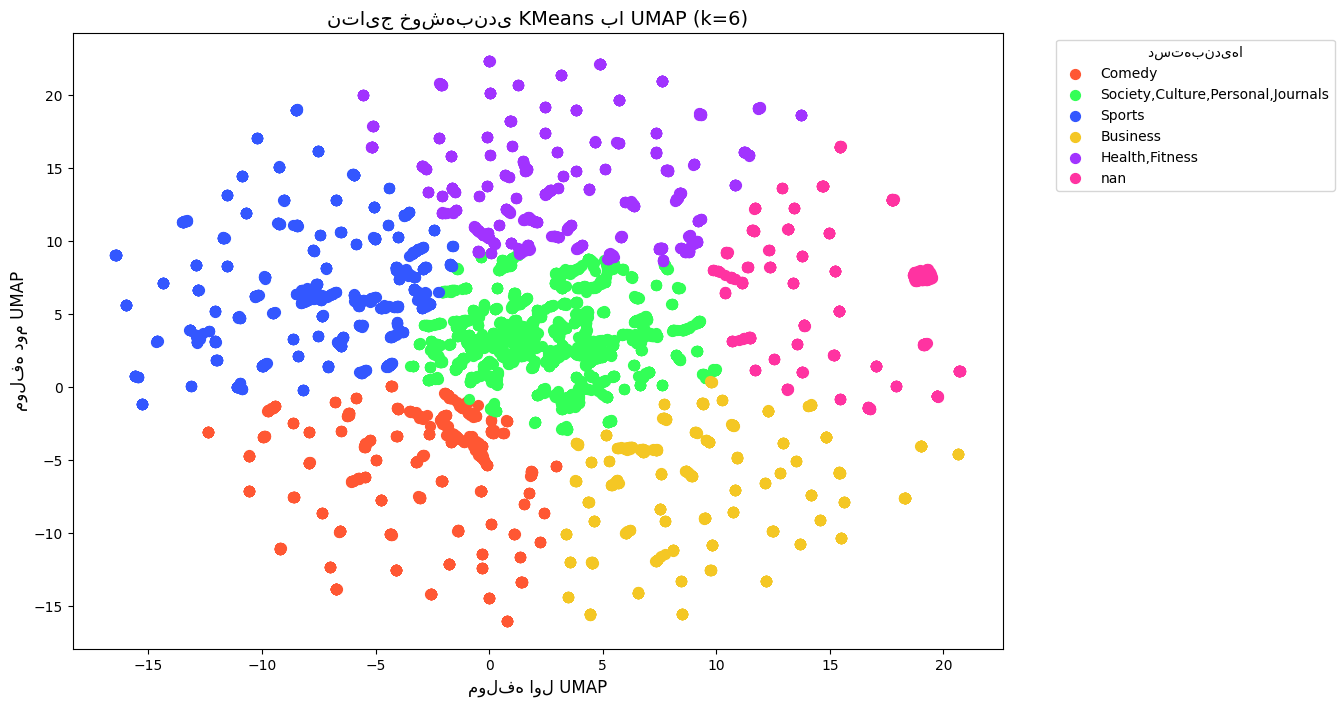

In [ ]:
# حذف مقادیر خالی و نامعتبر در ستون 'categories'
data = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# بارگذاری مدل و توکنایزر
model_ckpt = "sentence-transformers/paraphrase-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# تابع برای ایجاد Embedding با پردازش گروهی
def encode_texts(texts, tokenizer, model, device, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# ایجاد Embedding برای داده‌ها
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# کاهش ابعاد با UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.05, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# انتخاب تعداد خوشه‌ها
optimal_k = 6

# خوشه‌بندی با KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# ایجاد نگاشت نام دسته‌بندی‌ها به خوشه‌ها
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# تعریف رنگ‌های اختصاصی برای هر خوشه
cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

# نمایش نتایج خوشه‌بندی
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

answer7: sentence-transformers/all-MiniLM-L12-v2 + Embedding + UMAP + KMEANS

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


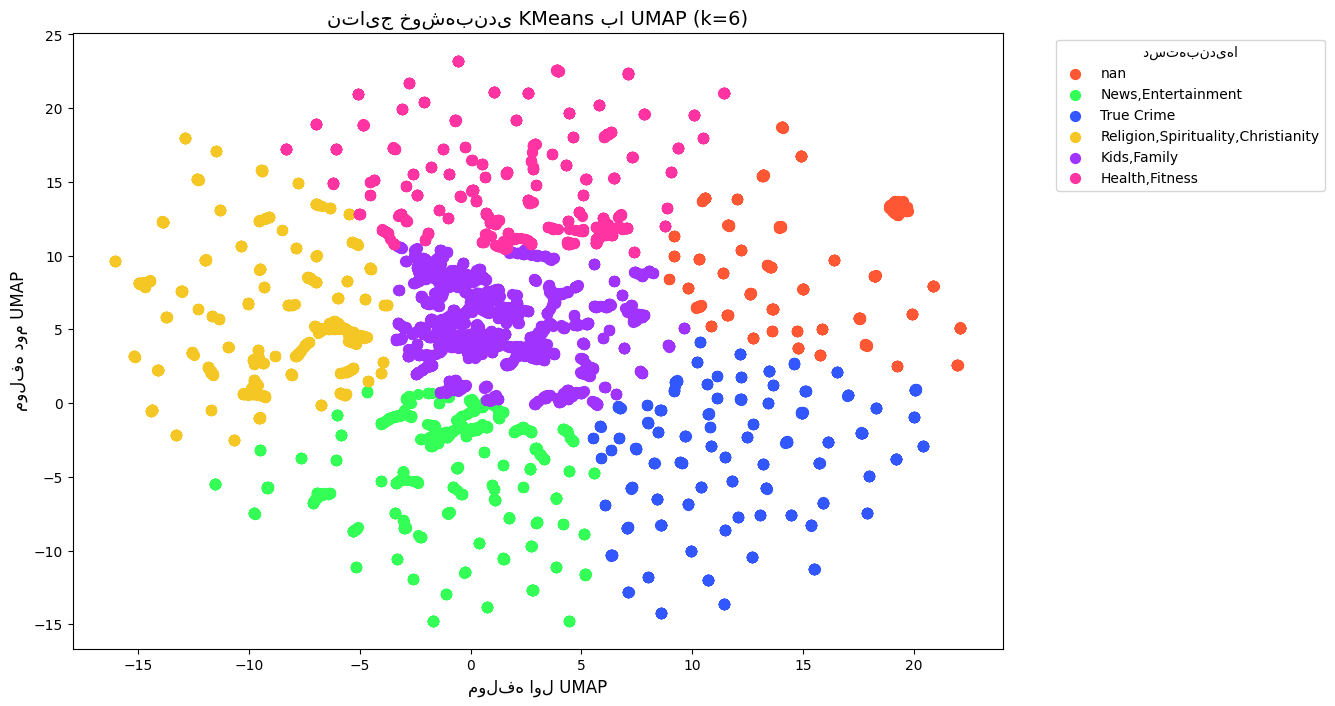

In [ ]:
# بارگذاری مدل و توکنایزر (مدل قوی‌تر)
model_ckpt = "sentence-transformers/all-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# تابع برای ایجاد Embedding با پردازش گروهی
def encode_texts(texts, tokenizer, model, device, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# ایجاد Embedding برای داده‌ها
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# کاهش ابعاد با UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.05, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# انتخاب تعداد خوشه‌ها
optimal_k = 6

# خوشه‌بندی با KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# ایجاد نگاشت نام دسته‌بندی‌ها به خوشه‌ها
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# تعریف رنگ‌های اختصاصی برای هر خوشه
cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

# نمایش نتایج خوشه‌بندی
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


answer8: sentence-transformers/all-mpnet-base-v2 + umap + kmeans

<ipython-input-17-fc30cd851c11>:11: DtypeWarning: Columns (2,3,8,9,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,27

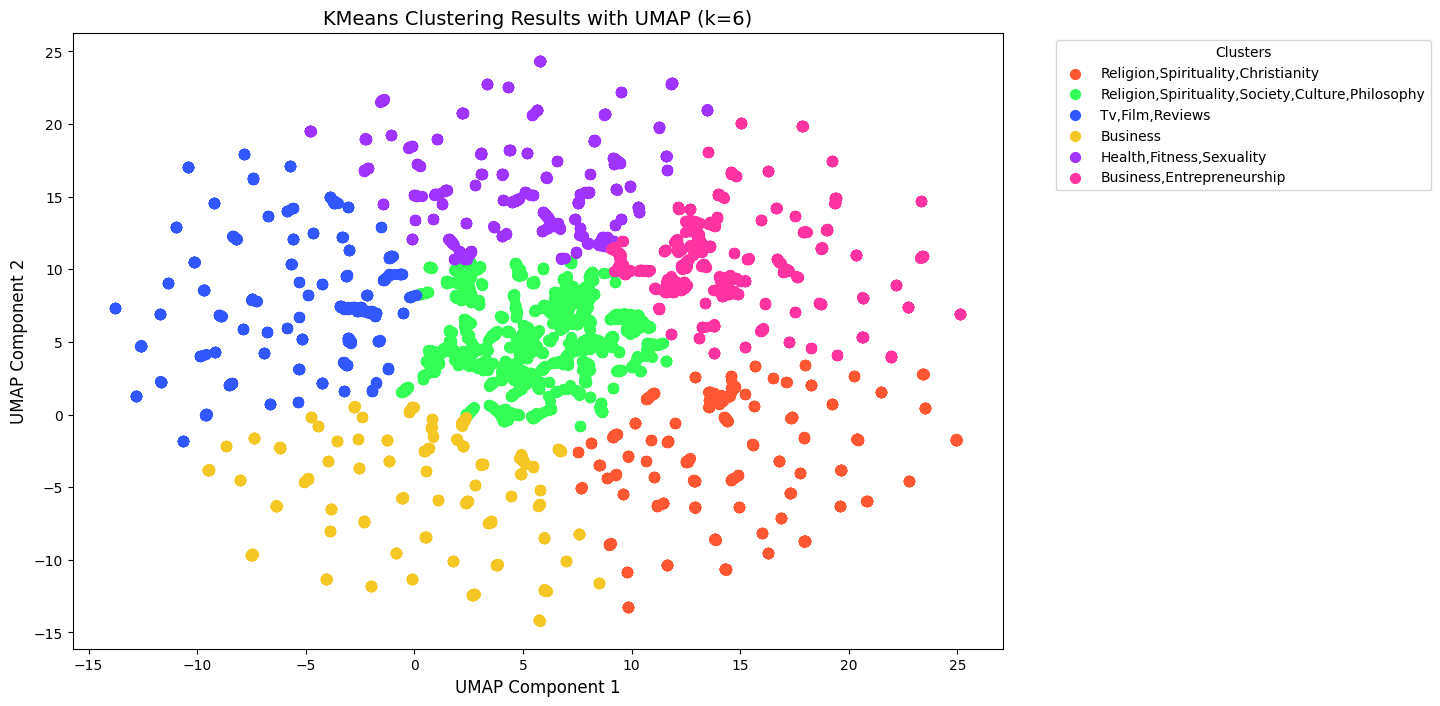

In [ ]:
# Remove empty and invalid values in the 'categories' column
data = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# Load the model and tokenizer (stronger model)
model_ckpt = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# Function to create embeddings with batch processing
def encode_texts(texts, tokenizer, model, device, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# Create embeddings for the data
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# Dimensionality reduction with UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.05, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# Select the number of clusters
optimal_k = 6

# Clustering with KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# Create a mapping of cluster names to clusters
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# Define custom colors for each cluster
cluster_colors = {
    0: "#FF5733",  # Red
    1: "#33FF57",  # Green
    2: "#3357FF",  # Blue
    3: "#F4C724",  # Yellow
    4: "#A133FF",  # Purple
    5: "#FF33A1",  # Pink
}

# Visualize the clustering results
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"Cluster {cluster_id}"),
                color=color, s=50)

plt.title(f'KMeans Clustering Results with UMAP (k={optimal_k})', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


answer9: BAAI/bge-large-en-v1.5 + umap + kmeans

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


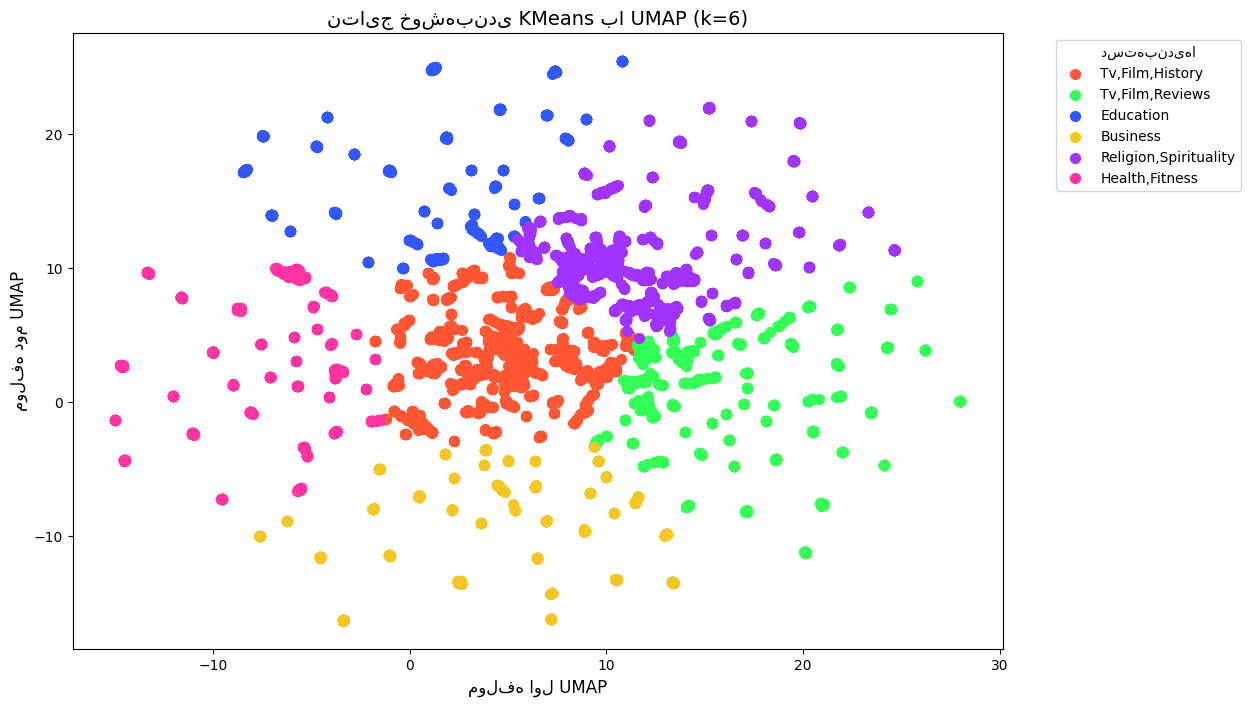

In [ ]:
# حذف مقادیر خالی و نامعتبر در ستون 'categories'
data = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# بارگذاری مدل و توکنایزر (مدل بسیار قوی‌تر)
model_ckpt = "BAAI/bge-large-en-v1.5"  # یا "intfloat/multilingual-e5-large" برای داده‌های چندزبانه
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# تابع برای ایجاد Embedding با پردازش گروهی
def encode_texts(texts, tokenizer, model, device, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # استفاده از [CLS] توکن برای دقت بالاتر
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# ایجاد Embedding برای داده‌ها
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# کاهش ابعاد با UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# انتخاب تعداد خوشه‌ها
optimal_k = 6

# خوشه‌بندی با KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# ایجاد نگاشت نام دسته‌بندی‌ها به خوشه‌ها
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# تعریف رنگ‌های اختصاصی برای هر خوشه
cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

# نمایش نتایج خوشه‌بندی
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


answer10: intfloat/e5-large-v2 + umap + kmeans

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


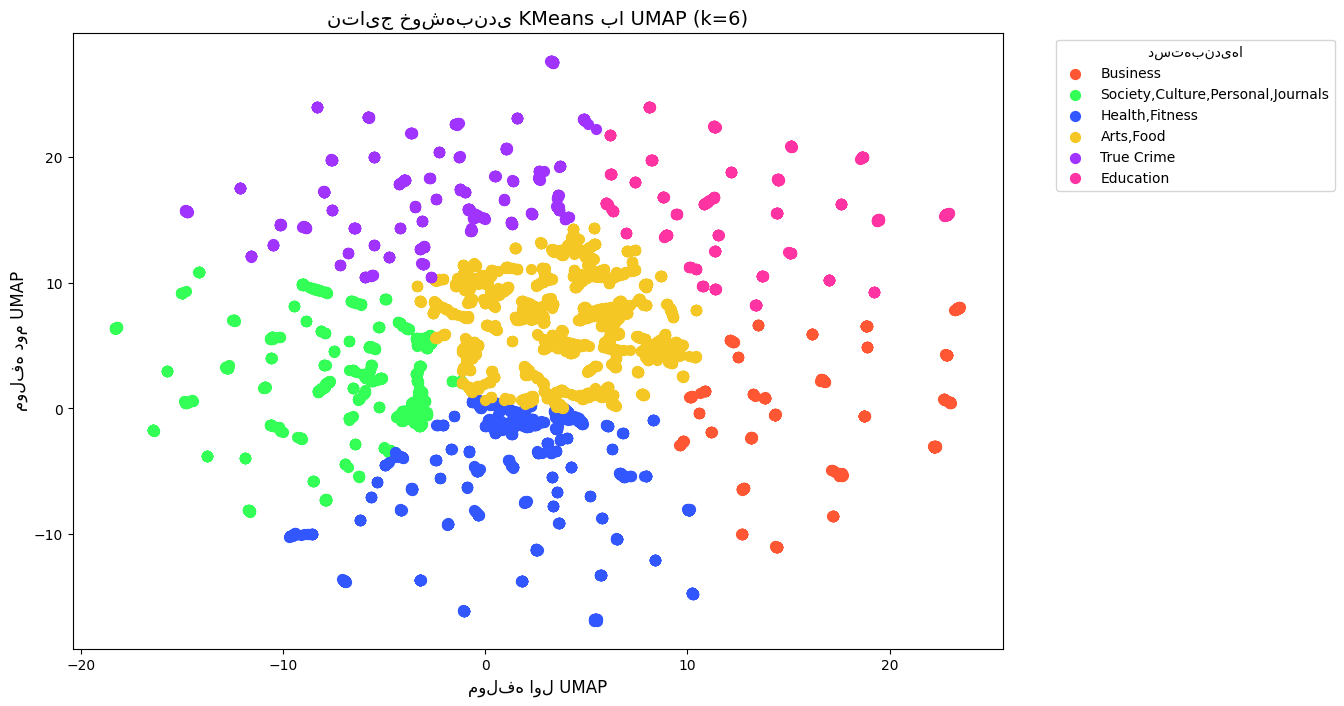

In [ ]:
# حذف مقادیر خالی و نامعتبر در ستون 'categories'
data = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# بارگذاری مدل و توکنایزر (مدل بسیار پیشرفته‌تر)
model_ckpt = "intfloat/e5-large-v2"  # یا "nomic-ai/nomic-embed-text-v1" برای embedding عمیق‌تر
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained(model_ckpt).to(device)

# تابع برای ایجاد Embedding با پردازش گروهی
def encode_texts(texts, tokenizer, model, device, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # استفاده از [CLS] توکن برای دقت بالاتر
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# ایجاد Embedding برای داده‌ها
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# کاهش ابعاد با UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# انتخاب تعداد خوشه‌ها
optimal_k = 6

# خوشه‌بندی با KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# ایجاد نگاشت نام دسته‌بندی‌ها به خوشه‌ها
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# تعریف رنگ‌های اختصاصی برای هر خوشه
cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

# نمایش نتایج خوشه‌بندی
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

answer11: nomic-ai/nomic-embed-text-v1 + UMAP + KMEANS

modeling_hf_nomic_bert.py:   0%|          | 0.00/103k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/547M [00:00<?, ?B/s]

/root/.cache/huggingface/modules/transformers_modules/nomic-ai/nomic-bert-2048/359596ab182dcf943b7ca9e3f8809b6c2eaf652f/modeling_hf_nomic_bert.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

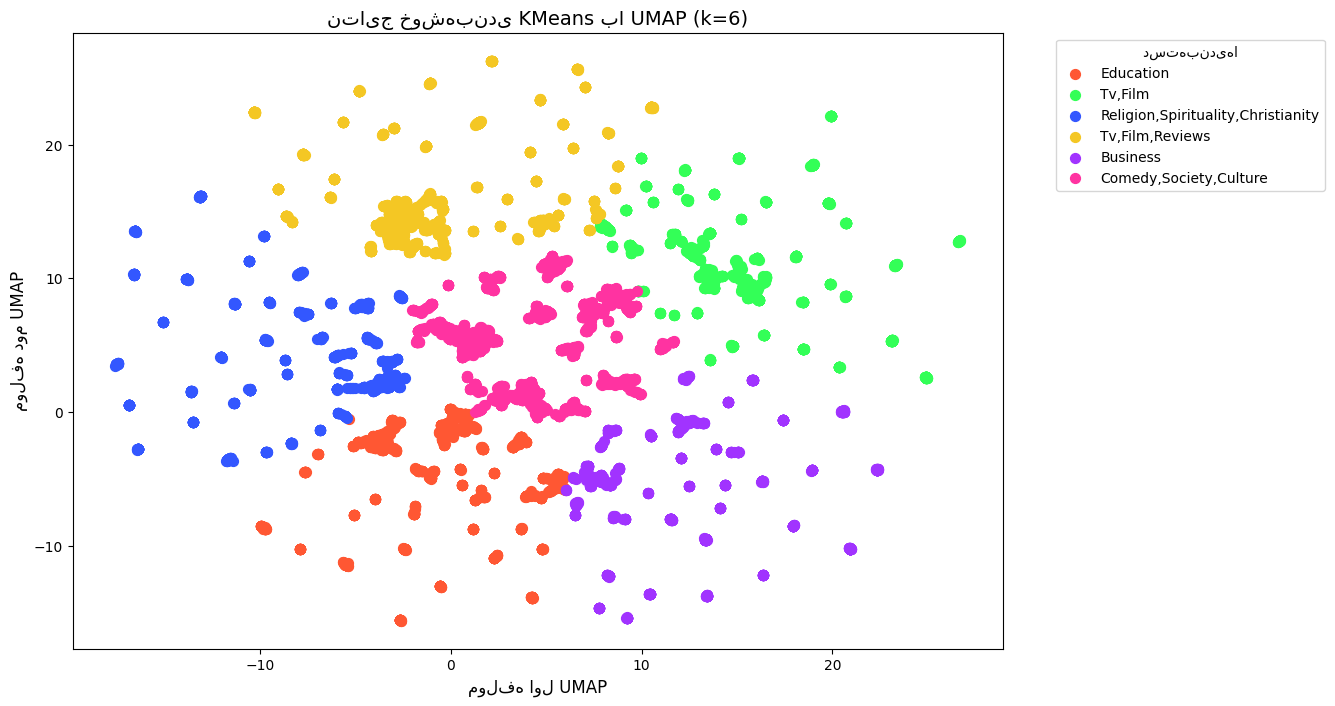

In [ ]:
# حذف مقادیر خالی و نامعتبر در ستون 'categories'
data = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# بارگذاری مدل و توکنایزر (مدل بسیار پیشرفته‌تر)
model_ckpt = "nomic-ai/nomic-embed-text-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained(model_ckpt, trust_remote_code=True).to(device)

# تابع برای ایجاد Embedding با پردازش گروهی
def encode_texts(texts, tokenizer, model, device, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # استفاده از [CLS] توکن برای دقت بالاتر
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# ایجاد Embedding برای داده‌ها
encoded_texts = encode_texts(data['categories'].tolist(), tokenizer, embedding_model, device)

# کاهش ابعاد با UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# انتخاب تعداد خوشه‌ها
optimal_k = 6

# خوشه‌بندی با KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# ایجاد نگاشت نام دسته‌بندی‌ها به خوشه‌ها
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# تعریف رنگ‌های اختصاصی برای هر خوشه
cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

# نمایش نتایج خوشه‌بندی
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

answer12: all-mpnet-base-v2 + umap + kmeans

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


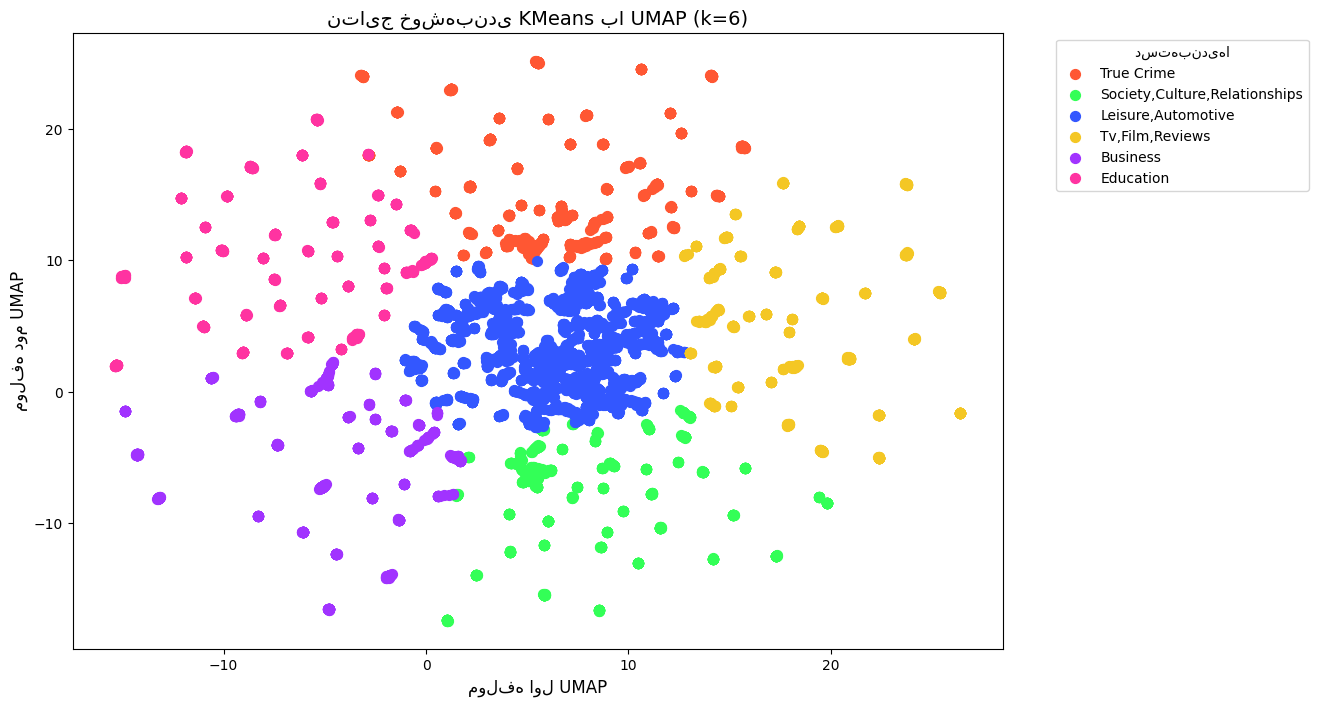

In [ ]:
ata = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# بارگذاری مدل Sentence Transformers
model = SentenceTransformer('all-mpnet-base-v2')

# ایجاد Embedding برای داده‌ها
encoded_texts = model.encode(data['categories'].tolist())

# کاهش ابعاد با UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# خوشه‌بندی با KMeans
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# نمایش نتایج
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

answer13: all-mpnet-base-v2 + silhouette_score = kmeans = umap

در حال ایجاد Embedding برای داده‌ها...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

در حال کاهش ابعاد با UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


در حال محاسبه تعداد بهینه خوشه‌ها...
Silhouette Score: 0.38


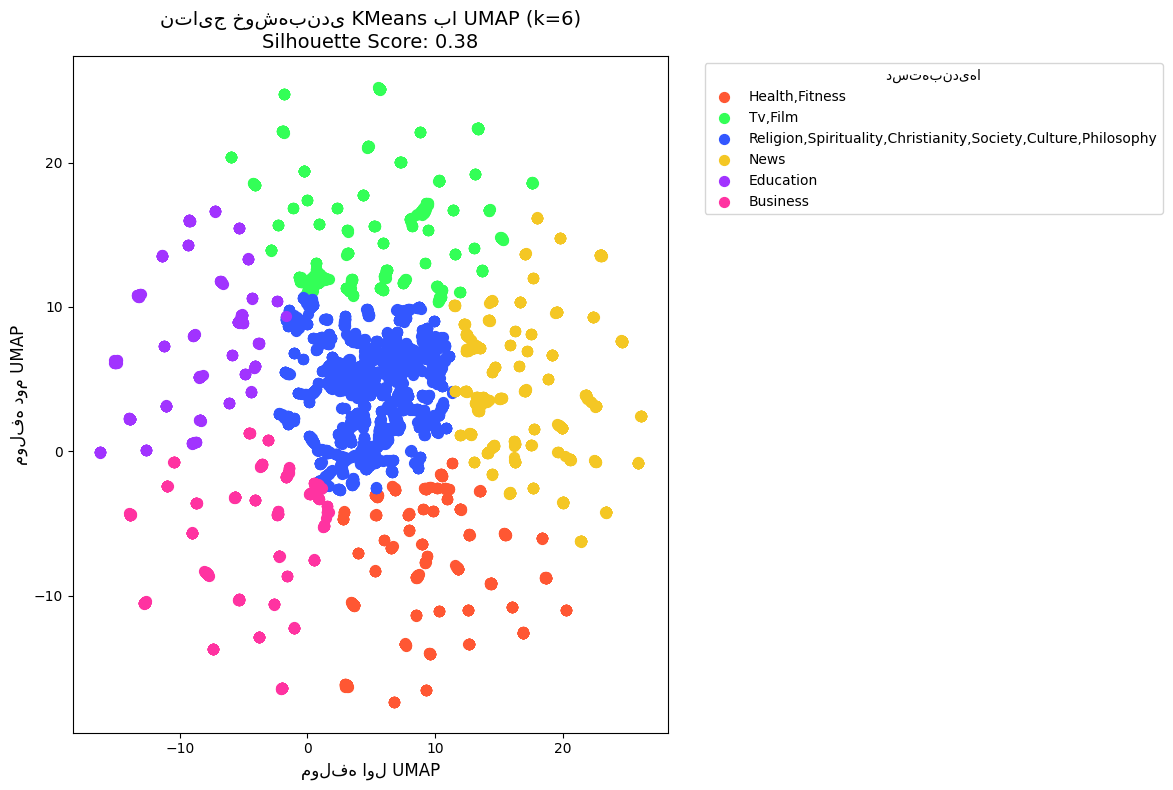

In [ ]:
# حذف مقادیر خالی و نامعتبر در ستون 'categories'
data = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# بارگذاری مدل Sentence Transformers (مدل پیشرفته‌تر)
model = SentenceTransformer('all-mpnet-base-v2')

# ایجاد Embedding برای داده‌ها
print("در حال ایجاد Embedding برای داده‌ها...")
encoded_texts = model.encode(data['categories'].tolist(), show_progress_bar=True)

# کاهش ابعاد با UMAP
print("در حال کاهش ابعاد با UMAP...")
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# تعیین تعداد بهینه خوشه‌ها با استفاده از Silhouette Score
print("در حال محاسبه تعداد بهینه خوشه‌ها...")
optimal_k = 6  # می‌توانید این مقدار را با روش‌هایی مانند Elbow Method یا Silhouette Score بهینه‌سازی کنید
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# محاسبه Silhouette Score برای ارزیابی خوشه‌بندی
silhouette_avg = silhouette_score(umap_embeddings, labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# ایجاد نگاشت نام دسته‌بندی‌ها به خوشه‌ها
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# تعریف رنگ‌های اختصاصی برای هر خوشه
cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

# نمایش نتایج خوشه‌بندی
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})\nSilhouette Score: {silhouette_avg:.2f}', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

answer14: paraphrase-multilingual-mpnet-base-v2 + Embedding + umap + kmeans + Silhouette Score

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

در حال ایجاد Embedding برای داده‌ها...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

در حال کاهش ابعاد با UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


در حال خوشه‌بندی با KMeans...
Silhouette Score: 0.37


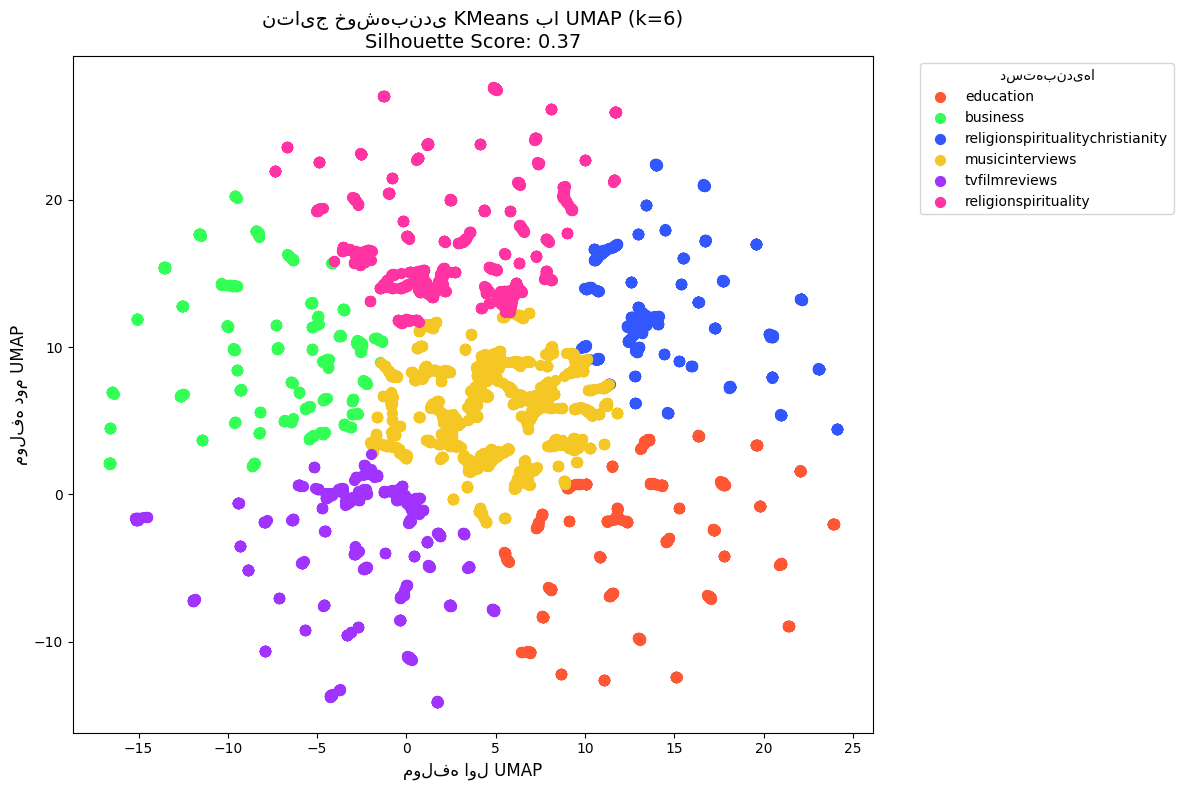

In [ ]:
# حذف مقادیر خالی و نامعتبر در ستون 'categories'
data = data.dropna(subset=['categories'])
data = data[data['categories'].apply(lambda x: isinstance(x, str))]

# پیش‌پردازش متن (حذف stop words و نرمال‌سازی)
def preprocess_text(text):
    # حذف علائم نگارشی و اعداد
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # تبدیل به حروف کوچک
    text = text.lower()
    return text

data['categories'] = data['categories'].apply(preprocess_text)

# بارگذاری مدل پیشرفته (بدون نیاز به API Key)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# ایجاد Embedding برای داده‌ها
print("در حال ایجاد Embedding برای داده‌ها...")
encoded_texts = model.encode(data['categories'].tolist(), show_progress_bar=True)

# کاهش ابعاد با UMAP (تنظیمات بهینه)
print("در حال کاهش ابعاد با UMAP...")
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(encoded_texts)

# انتخاب تعداد بهینه خوشه‌ها با استفاده از Elbow Method یا Silhouette Score
optimal_k = 6  # می‌توانید این مقدار را با روش‌هایی مانند Elbow Method یا Silhouette Score بهینه‌سازی کنید

# خوشه‌بندی با KMeans
print("در حال خوشه‌بندی با KMeans...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

# محاسبه Silhouette Score برای ارزیابی خوشه‌بندی
silhouette_avg = silhouette_score(umap_embeddings, labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# ایجاد نگاشت نام دسته‌بندی‌ها به خوشه‌ها
data['cluster'] = labels
cluster_names = data.groupby('cluster')['categories'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# تعریف رنگ‌های اختصاصی برای هر خوشه
cluster_colors = {
    0: "#FF5733",  # قرمز
    1: "#33FF57",  # سبز
    2: "#3357FF",  # آبی
    3: "#F4C724",  # زرد
    4: "#A133FF",  # بنفش
    5: "#FF33A1",  # صورتی
}

# نمایش نتایج خوشه‌بندی
plt.figure(figsize=(12, 8))
for cluster_id, color in cluster_colors.items():
    mask = labels == cluster_id
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=cluster_names.get(cluster_id, f"خوشه {cluster_id}"),
                color=color, s=50)

plt.title(f'نتایج خوشه‌بندی KMeans با UMAP (k={optimal_k})\nSilhouette Score: {silhouette_avg:.2f}', fontsize=14)
plt.xlabel('مولفه اول UMAP', fontsize=12)
plt.ylabel('مولفه دوم UMAP', fontsize=12)
plt.legend(title='دسته‌بندی‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# MOSTAFA SALARVANDIAN

نتیجه: مدل های پیشرفته تر که در جواب های انتهایی نوشته شده با ترکیب UMAP و KMEANS بهترین نتیجه برای این پروژه بود